In [1]:
!pip install git+https://github.com/keras-team/keras-tuner
# !pip uninstall tensorflow -y
# !pip install tensorflow-gpu
!pip install gdown

  Cloning https://github.com/keras-team/keras-tuner to /tmp/pip-req-build-11m2bb_7
  Running command git clone -q https://github.com/keras-team/keras-tuner /tmp/pip-req-build-11m2bb_7
  Created wheel for keras-tuner: filename=keras_tuner-0.9.1-cp36-none-any.whl size=85887 sha256=cbd6effeea683e7e7bf0c1f41ebc453363e8f4f156bc04d486a398eb78098648
  Stored in directory: /tmp/pip-ephem-wheel-cache-vg86sw5y/wheels/6c/55/2d/6e178386cb7a2d7da5a7059752a2b58791705c9c8718c5f07a
Successfully built keras-tuner


In [0]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pprint import pprint
from kerastuner.tuners import RandomSearch, BayesianOptimization

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
!gdown --id 1uWHjZ3y9XZKpcJ4fkSwjQJ-VDbZS-7xi --output titanic.csv

Downloading...
From: https://drive.google.com/uc?id=1uWHjZ3y9XZKpcJ4fkSwjQJ-VDbZS-7xi
To: /content/titanic.csv
100% 61.2k/61.2k [00:00<00:00, 21.6MB/s]


In [0]:
df = pd.read_csv('titanic.csv')

In [5]:
df.shape

(891, 12)

In [6]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

# Exploration

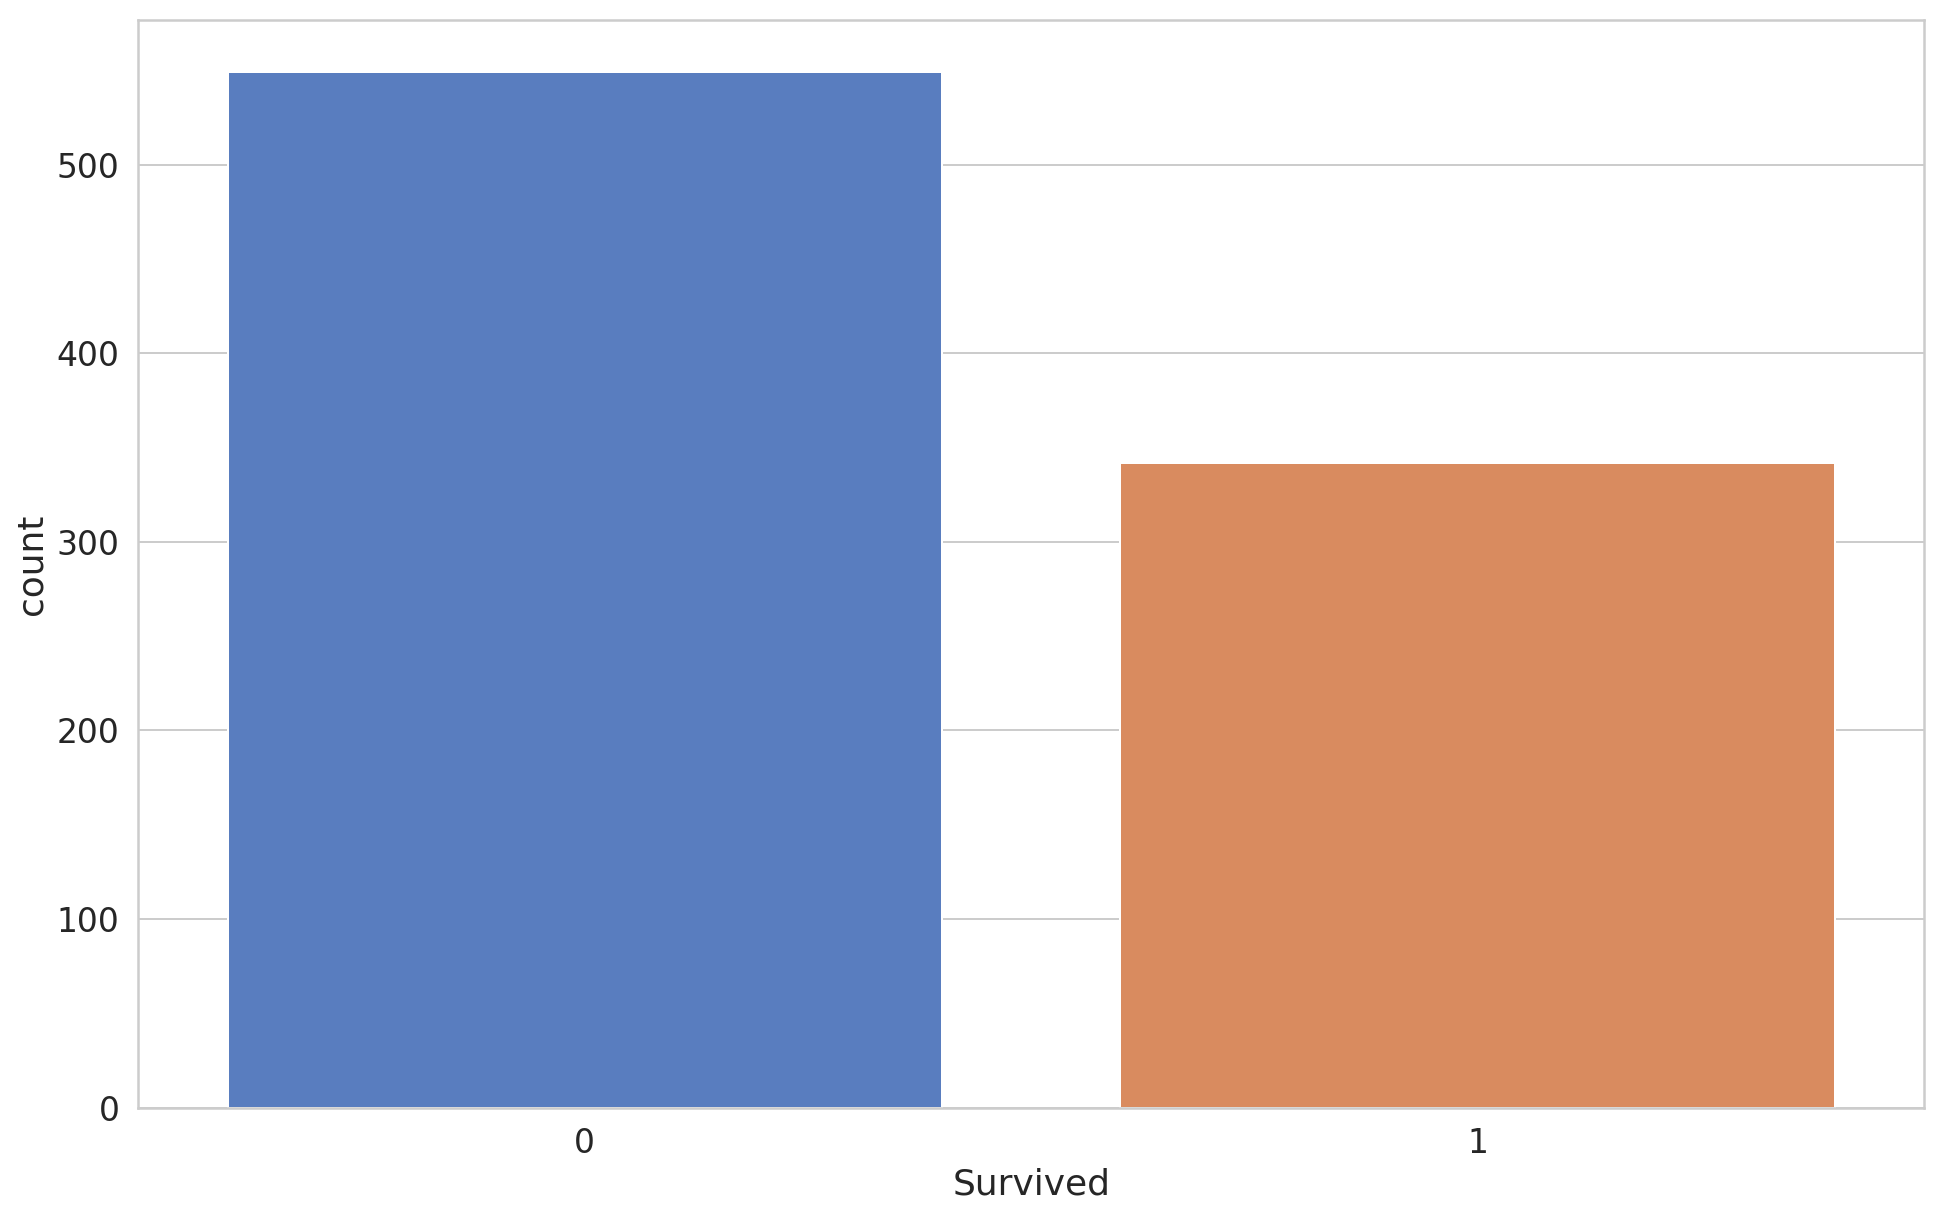

In [7]:
sns.countplot(df.Survived);

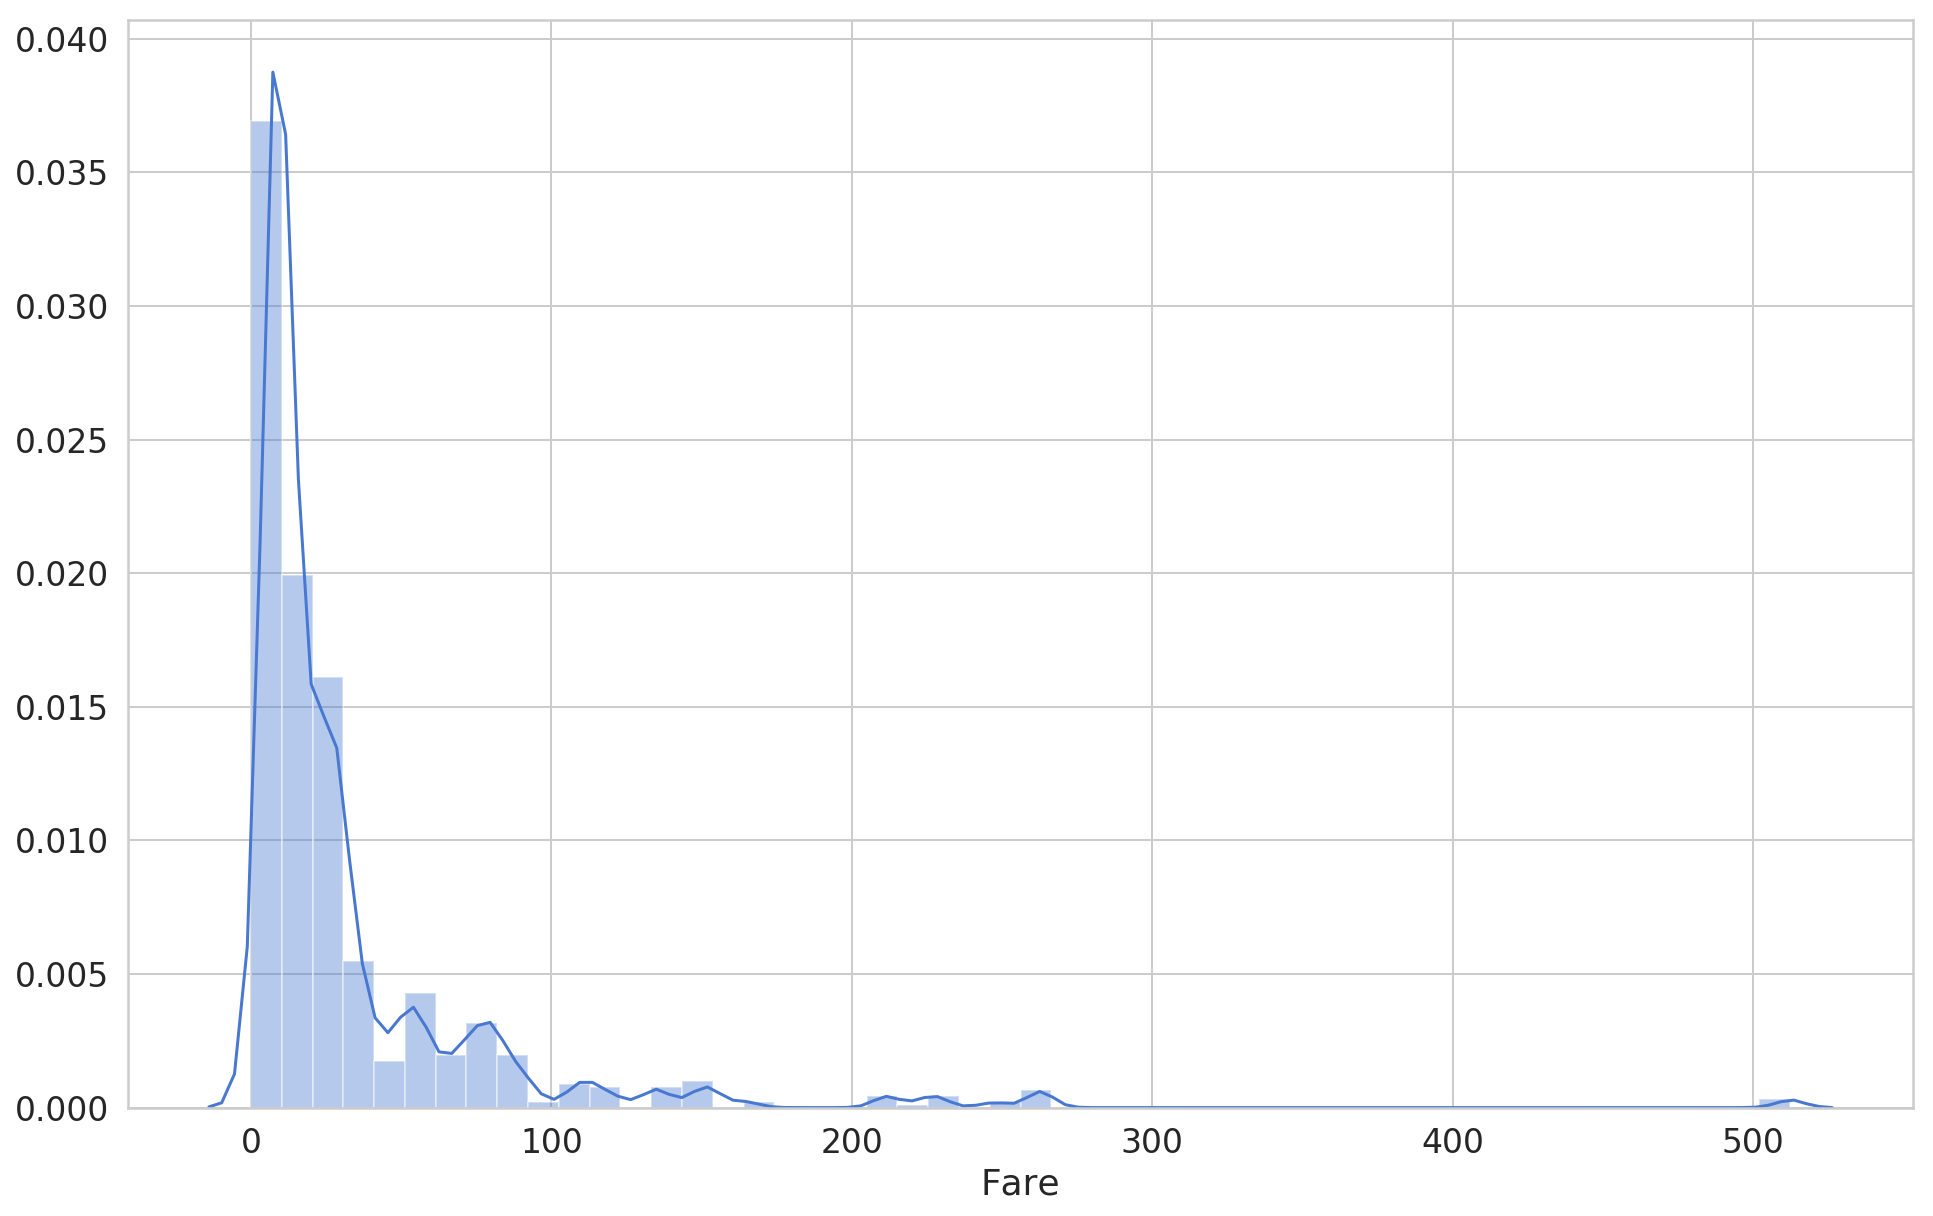

In [8]:
sns.distplot(df.Fare);

# Preprocessing

## Missing data

In [9]:
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

Cabin       687
Age         177
Embarked      2
dtype: int64

In [0]:
df = df.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1)

In [11]:
df.shape

(891, 8)

### Imputation

In [0]:
df['Age'] = df['Age'].fillna(df['Age'].mean())

In [0]:
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

## Categorical features

In [14]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [0]:
df = pd.get_dummies(df, columns=['Sex', 'Embarked', 'Pclass'])

In [0]:
X = df.drop('Survived', axis=1)
y = df.Survived

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Hyperparameter tuning

## Optimizer

In [0]:
def tune_optimizer_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=18, activation="relu", input_shape=[X_train.shape[1]]))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])

    model.compile(
        optimizer=optimizer,
        loss = 'binary_crossentropy', 
        metrics = ['accuracy'])
    return model

In [19]:
MAX_TRIALS = 20
EXECUTIONS_PER_TRIAL = 5

tuner = RandomSearch(
    tune_optimizer_model,
    objective='val_accuracy',
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTIONS_PER_TRIAL,
    directory='test_dir', 
    project_name='tune_optimizer',
    seed=RANDOM_SEED
)

tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from test_dir/tune_optimizer/oracle.json
INFO:tensorflow:Reloading Tuner from test_dir/tune_optimizer/tuner0.json


In [20]:
TRAIN_EPOCHS = 20

tuner.search(x=X_train,
             y=y_train,
             epochs=TRAIN_EPOCHS,
             validation_data=(X_test, y_test))

INFO:tensorflow:Oracle triggered exit


In [21]:
tuner.results_summary()

In [22]:
tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

{'optimizer': 'adam'}

In [0]:
best_model = tuner.get_best_models()[0]

In [24]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 18)                234       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 19        
Total params: 253
Trainable params: 253
Non-trainable params: 0
_________________________________________________________________


## Learning rate and Momentum

In [0]:
def tune_rl_momentum_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=18, activation="relu", input_shape=[X_train.shape[1]]))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    momentum = hp.Choice('momentum', [0.0, 0.2, 0.4, 0.6, 0.8, 0.9])

    model.compile(
        optimizer=keras.optimizers.SGD(lr, momentum=momentum),
        loss = 'binary_crossentropy', 
        metrics = ['accuracy'])
    return model

In [0]:
def create_random_tuner(model_builder, project_name):
  tuner = RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTIONS_PER_TRIAL,
    directory='test_dir', 
    project_name=project_name,
    seed=RANDOM_SEED
  )

  tuner.search_space_summary()
  return tuner

In [0]:
def random_search_params(model_builder, project_name):
  tuner = create_random_tuner(model_builder, project_name)
  tuner.search(x=X_train,
             y=y_train,
             epochs=TRAIN_EPOCHS,
             validation_data=(X_test, y_test))
  
  tuner.results_summary()

  pprint(tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values)

In [28]:
random_search_params(tune_rl_momentum_model, project_name="tune_lr_momentum")

INFO:tensorflow:Reloading Oracle from test_dir/tune_lr_momentum/oracle.json
INFO:tensorflow:Reloading Tuner from test_dir/tune_lr_momentum/tuner0.json


INFO:tensorflow:Oracle triggered exit


{'learning_rate': 0.01, 'momentum': 0.4}


# Number of parameters

In [0]:
def tune_neurons_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=hp.Int('units',
                                        min_value=8,
                                        max_value=128,
                                        step=16),
                                 activation="relu", 
                                 input_shape=[X_train.shape[1]]))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer="adam",
        loss = 'binary_crossentropy', 
        metrics = ['accuracy'])
    return model

In [30]:
random_search_params(tune_neurons_model, project_name="tune_neurons")

INFO:tensorflow:Reloading Oracle from test_dir/tune_neurons/oracle.json
INFO:tensorflow:Reloading Tuner from test_dir/tune_neurons/tuner0.json


INFO:tensorflow:Oracle triggered exit


{'units': 72}


# Number of hidden layers

In [0]:
def tune_layers_model(hp):
    model = keras.Sequential()

    model.add(keras.layers.Dense(units=128,
                                 activation="relu", 
                                 input_shape=[X_train.shape[1]]))

    for i in range(hp.Int('num_layers', 1, 6)):
      model.add(keras.layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=8,
                                            max_value=64,
                                            step=8),
                               activation='relu'))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer="adam",
        loss = 'binary_crossentropy', 
        metrics = ['accuracy'])
    return model

In [32]:
random_search_params(tune_layers_model, project_name="tune_layers")

INFO:tensorflow:Reloading Oracle from test_dir/tune_layers/oracle.json
INFO:tensorflow:Reloading Tuner from test_dir/tune_layers/tuner0.json


INFO:tensorflow:Oracle triggered exit


{'num_layers': 2,
 'units_0': 32,
 'units_1': 24,
 'units_2': 64,
 'units_3': 8,
 'units_4': 48,
 'units_5': 64}


# Weight initialization

In [0]:
def tune_weight_init_model(hp):
    model = keras.Sequential()

    weight_init = hp.Choice('weight_init', 
                            ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])

    model.add(keras.layers.Dense(units=32,
                                 activation="relu",
                                 kernel_initializer=weight_init,
                                 input_shape=[X_train.shape[1]]))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer="adam",
        loss = 'binary_crossentropy', 
        metrics = ['accuracy'])
    return model

In [34]:
random_search_params(tune_weight_init_model, project_name="tune_weight_init")

INFO:tensorflow:Reloading Oracle from test_dir/tune_weight_init/oracle.json
INFO:tensorflow:Reloading Tuner from test_dir/tune_weight_init/tuner0.json


INFO:tensorflow:Oracle triggered exit


{'weight_init': 'lecun_uniform'}


# Activation function

In [0]:
def tune_act_model(hp):
    model = keras.Sequential()

    activation = hp.Choice('activation', 
                            ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'])

    model.add(keras.layers.Dense(units=32,
                                 activation=activation,
                                 input_shape=[X_train.shape[1]]))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer="adam",
        loss = 'binary_crossentropy', 
        metrics = ['accuracy'])
    return model

In [36]:
random_search_params(tune_act_model, "tune_activation")

INFO:tensorflow:Reloading Oracle from test_dir/tune_activation/oracle.json
INFO:tensorflow:Reloading Tuner from test_dir/tune_activation/tuner0.json


INFO:tensorflow:Oracle triggered exit


{'activation': 'linear'}


# Dropout rate

In [0]:
def tune_dropout_model(hp):
    model = keras.Sequential()

    drop_rate = hp.Choice('drop_rate', 
                            [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    model.add(keras.layers.Dense(units=32,
                                 activation="relu",
                                 input_shape=[X_train.shape[1]]))
    model.add(keras.layers.Dropout(rate=drop_rate))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer="adam",
        loss = 'binary_crossentropy', 
        metrics = ['accuracy'])
    return model

In [38]:
random_search_params(tune_dropout_model, "tune_dropout")

INFO:tensorflow:Reloading Oracle from test_dir/tune_dropout/oracle.json
INFO:tensorflow:Reloading Tuner from test_dir/tune_dropout/tuner0.json


INFO:tensorflow:Oracle triggered exit


{'drop_rate': 0.0}


# Complete example

In [0]:
def tune_nn_model(hp):
    model = keras.Sequential()

    model.add(keras.layers.Dense(units=128,
                                 activation="relu", 
                                 input_shape=[X_train.shape[1]]))

    for i in range(hp.Int('num_layers', 1, 6)):
      units = hp.Int(
          'units_' + str(i), 
          min_value=8,
          max_value=64,
          step=8
      )
      model.add(keras.layers.Dense(units=units, activation='relu'))
      drop_rate = hp.Choice('drop_rate_' + str(i), 
                            [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
      model.add(keras.layers.Dropout(rate=drop_rate))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer="adam",
        loss = 'binary_crossentropy', 
        metrics = ['accuracy'])
    return model

In [40]:
random_search_params(tune_nn_model, "tune_nn")

INFO:tensorflow:Reloading Oracle from test_dir/tune_nn/oracle.json
INFO:tensorflow:Reloading Tuner from test_dir/tune_nn/tuner0.json


INFO:tensorflow:Oracle triggered exit


{'drop_rate_0': 0.1,
 'drop_rate_1': 0.6,
 'drop_rate_2': 0.8,
 'drop_rate_3': 0.8,
 'drop_rate_4': 0.9,
 'drop_rate_5': 0.2,
 'num_layers': 1,
 'units_0': 56,
 'units_1': 56,
 'units_2': 8,
 'units_3': 40,
 'units_4': 56,
 'units_5': 56}


# Bayesian Tuner

In [41]:
b_tuner = BayesianOptimization(
    tune_nn_model,
    objective='val_accuracy',
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTIONS_PER_TRIAL,
    directory='test_dir', 
    project_name='b_tune_nn',
    seed=RANDOM_SEED
)

b_tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from test_dir/b_tune_nn/oracle.json
INFO:tensorflow:Reloading Tuner from test_dir/b_tune_nn/tuner0.json


In [42]:
b_tuner.search(x=X_train,
             y=y_train,
             epochs=TRAIN_EPOCHS,
             validation_data=(X_test, y_test))
  
b_tuner.results_summary()

pprint(b_tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values)

INFO:tensorflow:Oracle triggered exit


{'drop_rate_0': 0.1,
 'drop_rate_1': 0.3,
 'drop_rate_2': 0.8,
 'drop_rate_3': 0.2,
 'drop_rate_4': 0.2,
 'drop_rate_5': 0.2,
 'num_layers': 2,
 'units_0': 24,
 'units_1': 56,
 'units_2': 16,
 'units_3': 64,
 'units_4': 64,
 'units_5': 32}


# Scikit-learn

In [0]:
import kerastuner as kt
from sklearn import ensemble
from sklearn import metrics
from sklearn import datasets
from sklearn import model_selection

In [44]:
def build_tree_model(hp):      
  return ensemble.RandomForestClassifier(
      n_estimators=hp.Int('n_estimators', 10, 80, step=5),
      max_depth=hp.Int('max_depth', 3, 10, step=1),
      max_features=hp.Choice('max_features', ['auto', 'sqrt', 'log2'])
  )

sk_tuner = kt.tuners.Sklearn(
  oracle=kt.oracles.BayesianOptimization(
      objective=kt.Objective('score', 'max'),
      max_trials=MAX_TRIALS,
      seed=RANDOM_SEED
  ),
  hypermodel=build_tree_model,
  scoring=metrics.make_scorer(metrics.accuracy_score),
  cv=model_selection.StratifiedKFold(5),
  directory='test_dir',
  project_name='tune_rf'
)

INFO:tensorflow:Reloading Oracle from test_dir/tune_rf/oracle.json
INFO:tensorflow:Reloading Tuner from test_dir/tune_rf/tuner0.json


In [45]:
sk_tuner.search(X_train.values, y_train.values)

INFO:tensorflow:Oracle triggered exit


In [47]:
sk_tuner.results_summary()

In [46]:
pprint(sk_tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values)

{'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 60}
